In [12]:

# get processed data

import os
import pandas as pd

file_path = "../data/"

data = pd.read_csv(file_path+"train.csv")


# Convert to list

df=data["news_title"]

docs = [str(i) for i in df.values]

docs=docs[:10000]



import torch
from transformers import BertModel, BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
model = BertModel.from_pretrained("setu4993/LaBSE")

# Set model to evaluation mode

model.eval()


"""
Encode a batch of documents using LaBSE model and return their embeddings.
Args:
    docs: List of strings representing the documents to be encoded.
    batch_size: Size of the batch to be used during encoding.
Returns:
    embeddings: Tensor of shape (n_docs, embedding_size) representing the document embeddings.
"""
# Encode the documents in batches

n_docs = len(docs)
batch_size = 8
embeds = torch.zeros((n_docs, model.config.hidden_size))
for i in range(0, n_docs, batch_size):
    batch = docs[i:i+batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    batch_embeddings = outputs.pooler_output
    embeds[i:i+batch_size] = batch_embeddings




# Tokenize docs trivially (split on spaces)

from indicnlp.tokenize import sentence_tokenize, indic_tokenize

def tokenize_ta(text,return_tensors="pt",*args,**kwargs):
    return indic_tokenize.trivial_tokenize(text)


# Common list of stopwords

stopwords=['அங்கு',
 'அங்கே',
 'அடுத்த',
 'அதனால்',
 'அதன்',
 'அதற்கு',
 'அதிக',
 'அதில்',
 'அது',
 'அதே',
 'அதை',
 'அந்த',
 'அந்தக்',
 'அந்தப்',
 'அன்று',
 'அல்லது',
 'அவன்',
 'அவரது',
 'அவர்',
 'அவர்கள்',
 'அவள்',
 'அவை',
 'ஆகிய',
 'ஆகியோர்',
 'ஆகும்',
 'இங்கு',
 'இங்கே',
 'இடத்தில்',
 'இடம்',
 'இதனால்',
 'இதனை',
 'இதன்',
 'இதற்கு',
 'இதில்',
 'இது',
 'இதை',
 'இந்த',
 'இந்தக்',
 'இந்தத்',
 'இந்தப்',
 'இன்னும்',
 'இப்போது',
 'இரு',
 'இருக்கும்',
 'இருந்த',
 'இருந்தது',
 'இருந்து',
 'இவர்',
 'இவை',
 'உன்',
 'உள்ள',
 'உள்ளது',
 'உள்ளன',
 'எந்த',
 'என',
 'எனக்',
 'எனக்கு',
 'எனப்படும்',
 'எனவும்',
 'எனவே',
 'எனினும்',
 'எனும்',
 'என்',
 'என்ன',
 'என்னும்',
 'என்பது',
 'என்பதை',
 'என்ற',
 'என்று',
 'என்றும்',
 'எல்லாம்',
 'ஏன்',
 'ஒரு',
 'ஒரே',
 'ஓர்',
 'கொண்ட',
 'கொண்டு',
 'கொள்ள',
 'சற்று',
 'சிறு',
 'சில',
 'சேர்ந்த',
 'தனது',
 'தன்',
 'தவிர',
 'தான்',
 'நான்',
 'நாம்',
 'நீ',
 'பற்றி',
 'பற்றிய',
 'பல',
 'பலரும்',
 'பல்வேறு',
 'பின்',
 'பின்னர்',
 'பிற',
 'பிறகு',
 'பெரும்',
 'பேர்',
 'போது',
 'போன்ற',
 'போல',
 'போல்',
 'மட்டுமே',
 'மட்டும்',
 'மற்ற',
 'மற்றும்',
 'மிக',
 'மிகவும்',
 'மீது',
 'முதல்',
 'முறை',
 'மேலும்',
 'மேல்',
 'யார்',
 'வந்த',
 'வந்து',
 'வரும்',
 'வரை',
 'வரையில்',
 'விட',
 'விட்டு',
 'வேண்டும்',
 'வேறு']

from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts for topic representation - TOKENIZATION STEP

vectorizer_model = CountVectorizer(
    stop_words=stopwords,analyzer='word',
    tokenizer=tokenize_ta
)


# Create a BERTopic model

from bertopic import BERTopic

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    verbose=True,
    calculate_probabilities=False,
    embedding_model=model,
    
)

# Fit the model on the documents

embeds_np = embeds.detach().numpy()

topics = topic_model.fit_transform(docs,embeds_np)


2023-04-28 18:55:07,320 - BERTopic - Reduced dimensionality
2023-04-28 18:55:07,562 - BERTopic - Clustered reduced embeddings


In [13]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,3880,-1_கொலை_போலீஸ்_பெண்_வழக்கு
1,0,223,0_கோடி_லட்சம்_ஆயிரம்_பறிமுதல்
2,1,212,1_கோயில்_கோயிலில்_பக்தர்கள்_விழா
3,2,211,2_திமுக_அதிமுக_கூட்டணி_முகஸ்டாலின்
4,3,211,3_இந்தியா_இங்கிலாந்து_வெஸ்ட்_இலங்கை
...,...,...,...
155,154,11,154_குரேஷி_அதிகாரிகளுடன்_ஆலோசனை_தேர்தல்
156,155,10,155_புதுச்சேரியில்_விருதுநகர்_தொகுதியில்_அறந்த...
157,156,10,156_சதானந்த_கவுடா_புதிய_அதிகாரபூர்வ
158,157,10,157_வீரர்கள்_மனநோயாளிகள்_இறந்துவிட்டால்_விந்தண...


In [14]:
new_topics = topic_model.reduce_outliers(
    docs, topic_model.topics_, strategy="c-tf-idf")
topic_model.update_topics(
    docs, topics=new_topics, vectorizer_model=vectorizer_model)


In [15]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,64,-1_ஸ்டேட்_சம்திங்_ஷாருக்கான்_டும்
1,0,252,0_கோடி_ஆயிரம்_லட்சம்_பறிமுதல்
2,1,226,1_கோயில்_கோயிலில்_பக்தர்கள்_திருப்பதி
3,2,246,2_திமுக_அதிமுக_கூட்டணி_முகஸ்டாலின்
4,3,260,3_இந்தியா_இங்கிலாந்து_வெஸ்ட்_டெஸ்ட்
...,...,...,...
155,154,40,154_குரேஷி_ஆலோசனை_வருகை_அதிகாரிகளுடன்
156,155,24,155_புதுச்சேரியில்_தொகுதியில்_முன்னிலை_வைத்தில...
157,156,18,156_காலம்_கவுடா_அர்ஜுன்_ஜார்கண்ட்
158,157,26,157_வீரர்கள்_தென்கொரிய_வளர்க்க_பயிற்சி


In [16]:
df_with_topics = pd.DataFrame({'text':docs,'topic':topics[0]})

df_with_topics

,text,topic
0,தூக்கில் தொங்கும் சேவல்கள் திருடர்களை காவு வாங...,-1
1,பவுர்ணமி ஜாமத்தில் மாயமான கர்ப்பிணி,-1
2,மச்சுபிச்சு மலை ரகசியம்,-1
3,ரத்த பலி வாங்கும் விபரீத ஆவி,22
4,உலகப் பேரழகியின் மர்ம மரணம்,134
...,...,...
9995,காஞ்சியில் சமச்சீர் கல்வி வெற்றி விழா முகஸ்டால...,73
9996,தமிழகம் புதுச்சேரியில் இடி மின்னலுடன் மழை பெய்...,56
9997,புதிய தலைமை செயலக கட்டிடத்தில் சிறப்பு மருத்து...,7
9998,கூடங்குளத்தில் உளவுப்படை போலீஸ் தீவிர கண்காணிப்பு,-1


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [18]:

import numpy as np
# Define a function to generate recommendations using the same topic cluster method
def same_topic_recommend(article, df, embeds_np):
    # find all documents with same topic as sample article and get their embeddings from embeds_np
    same_topic_docs = df[df['topic'] == article['topic']]
    same_topic_docs_embeddings = embeds_np[same_topic_docs.index]

    article_embedding = embeds_np[article.name].reshape(1, -1)

    cosine_similarities = cosine_similarity(article_embedding, same_topic_docs_embeddings)
    
    # Get the indices that would sort the array in descending order
    sorted_indices = np.argsort(-cosine_similarities)

    # Sort the array in descending order based on the cosine similarity scores
    top_scores = cosine_similarities[0][sorted_indices][0][:5]

    # get top 5 scores

    return top_scores.mean()


In [19]:
# Define a function to generate recommendations using the entire dataset method
def all_articles_recommend(article, df, embeds_np):
    article_embedding = embeds_np[article.name].reshape(1, -1)
    cosine_similarities = cosine_similarity(article_embedding, embeds_np)
    # Get the indices that would sort the array in descending order
    sorted_indices = np.argsort(-cosine_similarities)

    # Sort the array in descending order based on the cosine similarity scores
    top_scores = cosine_similarities[0][sorted_indices][0][:5]

    # get top 5 scores

    return top_scores.mean()

In [20]:
from datetime import datetime


def evaluate_recommendations(df, embeds_np):
    # initialize list to store cosine similarity scores
    cos_sim_scores = []


    # loop through each article in the set
    for _, article in df.iterrows():
        # get the recommended articles using both methods
        start_time = datetime.now()
        method1_cos_sim_scores = same_topic_recommend(article, df, embeds_np)
        time_taken1 = datetime.now() - start_time
        time_taken1= time_taken1.total_seconds()


        start_time = datetime.now()
        method2_cos_sim_scores = all_articles_recommend(article, df, embeds_np)
        time_taken2 = datetime.now() - start_time
        time_taken2= time_taken2.total_seconds()

        # append the cosine similarity scores to the list
        cos_sim_scores.append([method1_cos_sim_scores, time_taken1,method2_cos_sim_scores,time_taken2])
    # convert the list to a pandas DataFrame
    cos_sim_scores_df = pd.DataFrame(cos_sim_scores, columns=['Same Topic','Time Taken for Same Topic method','All articles','Time Taken for All articles method'])

    # return the DataFrame
    return cos_sim_scores_df

In [21]:
scores_df=evaluate_recommendations(df_with_topics,embeds_np)
scores_df

,Same Topic,Time Taken for Same Topic method,All articles,Time Taken for All articles method
0,0.677057,0.009659,0.717874,0.011249
1,0.613259,0.007144,0.640931,0.060991
2,0.634265,0.013026,0.634265,0.031814
3,0.734044,0.004501,0.734044,0.020384
4,0.763832,0.000481,0.763832,0.010737
...,...,...,...,...
9995,0.640092,0.002822,0.665240,0.014408
9996,0.734379,0.000419,0.741732,0.012847
9997,0.744962,0.000530,0.744962,0.009590
9998,0.699978,0.006160,0.719250,0.015998


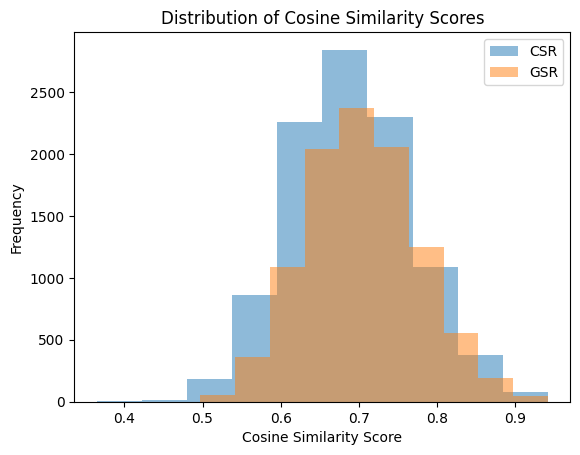

Mean cosine similarity (Clustered Semantic Recommender): 0.6896549
Average time taken for Clustered Semantic Recommender method: 0.0044585463
Mean cosine similarity (Global Similarity Recommender): 0.70480174
Average time taken for Global Similarity method: 0.0138745303


In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean cosine similarity for both methods

cosine_similarities_topic = scores_df['Same Topic']
cosine_similarities_all = scores_df['All articles']

mean_cosine_similarities_topic = np.mean(cosine_similarities_topic)
mean_cosine_similarities_all = np.mean(cosine_similarities_all)

# Plot distribution of cosine similarity scores
fig, ax = plt.subplots()
ax.hist(cosine_similarities_topic, alpha=0.5, label='CSR')
ax.hist(cosine_similarities_all, alpha=0.5, label='GSR')
ax.legend()
ax.set_xlabel('Cosine Similarity Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Cosine Similarity Scores')
plt.show()

# Print mean cosine similarity scores
print('Mean cosine similarity (Clustered Semantic Recommender):', mean_cosine_similarities_topic)
print('Average time taken for Clustered Semantic Recommender method:', scores_df['Time Taken for Same Topic method'].mean())
print('Mean cosine similarity (Global Similarity Recommender):', mean_cosine_similarities_all)
print('Average time taken for Global Similarity method:', scores_df['Time Taken for All articles method'].mean())

In [53]:

import numpy as np
# Define a function to generate recommendations using the same topic cluster method
def clustered_semantic_recommender(article, df, embeds_np):
    # find all documents with same topic as sample article and get their embeddings from embeds_np
    same_topic_docs = df[df['topic'] == article['topic']]
    same_topic_docs_embeddings = embeds_np[same_topic_docs.index]

    article_embedding = embeds_np[article.name].reshape(1, -1)

    cosine_similarities = cosine_similarity(article_embedding, same_topic_docs_embeddings)
    
    # Get the indices that would sort the array in descending order
    sorted_indices = np.argsort(-cosine_similarities)[0]

    # return the top 5 most similar articles excluding the sample article

    return same_topic_docs.iloc[sorted_indices[1:6]]

In [71]:
# Define a function to generate recommendations using the entire dataset method
def global_similarity_recommender(article, df, embeds_np):
    article_embedding = embeds_np[article.name].reshape(1, -1)
    cosine_similarities = cosine_similarity(article_embedding, embeds_np)
    # Get the indices that would sort the array in descending order
    sorted_indices = np.argsort(-cosine_similarities)

    # Get the indices that would sort the array in descending order
    sorted_indices = np.argsort(-cosine_similarities)[0]

    # return the top 5 most similar articles excluding the sample article

    return df.iloc[sorted_indices[1:6]]

In [76]:
sample_article = df_with_topics.sample(1).iloc[0]

sample_article['text']


'மயிலாப்பூரில் இன்று அறுபத்து மூவர் விழா'

In [77]:

# get recommendations using the clustered semantic recommender

clustered_semantic_recommender(sample_article, df_with_topics, embeds_np)



,text,topic
2663,மயிலாப்பூர் கபாலீஸ்வரர் கோயில் பங்குனி விழா தொ...,1
422,வது ஆராதனை விழா திருவையாறில் இன்று தொடக்கம்,1
2940,மயிலாப்பூரில் கபாலீஸ்வரர் கோயில் தேரோட்டம்,1
344,கபாலீஸ்வரர் கோயில் தைப்பூச விழா மயிலாப்பூரில் ...,1
4557,சோழிங்கநல்லூர் கோயிலில் மகா கும்பாபிஷேக விழா,1


In [78]:

# get recommendations using the global similarity recommender

global_similarity_recommender(sample_article, df_with_topics, embeds_np)



,text,topic
2663,மயிலாப்பூர் கபாலீஸ்வரர் கோயில் பங்குனி விழா தொ...,1
422,வது ஆராதனை விழா திருவையாறில் இன்று தொடக்கம்,1
2940,மயிலாப்பூரில் கபாலீஸ்வரர் கோயில் தேரோட்டம்,1
828,அனுப்பம்பட்டில் முப்பெரும் விழா,-1
344,கபாலீஸ்வரர் கோயில் தைப்பூச விழா மயிலாப்பூரில் ...,1
